# TD : Apprentissage automatique - Approches bayésienne et linéairement discriminante

Répondez aux questions dans le document et copiez les lignes de code qui ont produit les résultats aux endroits indiqués.

Les objectifs du TD sont:
* Une familiarisation avec la gestion de données.
* La mise en oeuvre d'une démarche de conception par apprentissage d'un classifieur sur des problèmes de petite taille (mais parfois de grande dimension).
* Une prise en main des ressources logicielles classiques utilisées en Machine Learning et Data Science.


______

# Introduction: Les ressources logicielles utiles
______

Dans ce TD, on utilise les ressources de calcul et l'environnement logiciel Python proposés par [Colab](https://colab.research.google.com/).

Les données seront accessibles depuis le site [openML](https://www.openml.org/) et seront téléchargées directement depuis ce site.

Il sera fait usage de la bibliothèque [scikit-learn](http://scikit-learn.org/stable/modules/classes.html) qui contient la plupart des algorithmes d'apprentissage classiques dans un format unifié.

D'autres bibliothèques utiles sont [pandas](https://pandas.pydata.org/) (manipulation de données) et [seaborn](https://seaborn.pydata.org/) (fonctions de visualisation): on en verra quelques exemples au cours du TD.

Les bibliothèques seront chargées au cours du TD en utilisant l'instruction Python  `import`.

Exécuter la cellule de code suivante pour charger les librairies utiles.

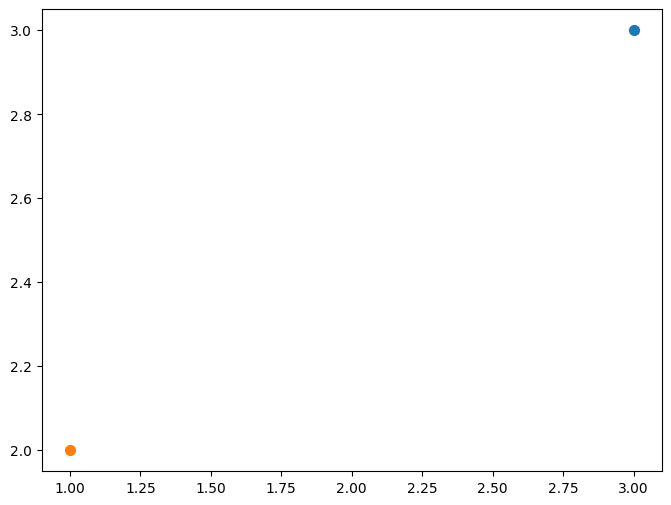

In [1]:
# Librairies scientifique et visualisation utiles standard
import numpy as np
import matplotlib.pyplot as plt

# Pour visualiser la répartition des données sur un plan
def show_data_2D(X,Y):
    np.unique(Y)
    fig, ax = plt.subplots(figsize=(8, 6))
    for id in np.unique(Y):
        idpositive=np.nonzero(Y == id)[0]
        ax.scatter(X[idpositive,0], X[idpositive,1], s=50)
show_data_2D(np.array([[1, 2], [3, 3]]), np.array([2, 1]))
plt.show()


______

# Partie 1: Les données
______

On se propose dans cette première partie de construire une démarche d'apprentissage sur un problème simple, et de programmer les algorithmes vus dans le cours (approches discriminantes et génératives).

Chaque jeu de données est constitué de quatre ensembles :
* Un ensemble de données utilisées pour l'apprentissage : X_train
* Un ensemble de classes associées aux données d'apprentissage : y_train
* Un ensemble de données à tester : X_test
* Un ensemble de classes associées aux données de test : y_test

Les données de test ne doivent pas être utilisées pour l'apprentissage proprement dit, seulement pour son évaluation.

Remarque: Pour visualiser dans le notebook, appliquer l'instruction:
>```python
plt.show()
```

après chaque fonction de visualisation.


## Familiarisation avec les données

On se propose de réaliser une classification binaire d'un ensemble de données en utilisant les approches décrites dans le cours.

Le problème est une classification binaire pour détecter des billets de banque frauduleux. Les données source d'origine sont accessibles [ici](https://www.openml.org/search?type=data&status=active&id=1462).

L'objectif est de dérouler les différentes étapes d'une démarche d'apprentissage automatique:
1. Constitution de la base d'apprentissage
2. Visualisation et analyse des données
3. Choix d'une approche
4. Optimisation (apprentissage des paramètres du prédicteur)
5. Evaluation


### Base d'apprentissage (10min)


Exécuter le code ci-dessous qui charge les données, et qui les répartit en ensemble d'apprentissage et de test (fonction 'train_test_split')

Montrer les tailles des données (nombre de caractéristiques, nombre de données).


In [4]:
# API pour récupérer les données sur openml.org
import openml

# Pour séparer les données en apprentissage et test
from sklearn.model_selection import train_test_split

# Chargement des données et constitution de la base d'apprentissage
dataset = openml.datasets.get_dataset('banknote-authentication')

# Get the data itself as a dataframe (or otherwise)
data_all, _, _, names = dataset.get_data(dataset_format="array")
print("Nom des colonnes: ", names)

y = data_all[:,-1]
X = data_all[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.8)

# Données d'apprentissage réparties en fonction des classes
X0 = X_train[y_train == 0,:]
X1 = X_train[y_train == 1,:]

##################
# MODIFIER LE CODE
ndim = 4
ntrain =int(len(data_all) * (2/10))
#################

print("Les données sont de dimension {:d}".format(ndim))
print("Le nombre de données d'apprentissage est {:d}".format(ntrain))


Nom des colonnes:  ['V1', 'V2', 'V3', 'V4', 'Class']
Les données sont de dimension 4
Le nombre de données d'apprentissage est 274


C:\Users\seydo\AppData\Local\Temp\ipykernel_10996\946996659.py:11: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  data_all, _, _, names = dataset.get_data(dataset_format="array")


### Visualisation des données

Jouer avec les visualisation des distributions de données en modifiant des paramètres du code ci-dessous et en éxécutant la cellule.

Vous pourrez utiliser les fonctions de visualisation "show_data_2D" pour mettre en évidence les corrélations, et [plt.hist](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html) pour visualiser des histogrammes pour chaque classe comme dans l'exemple.


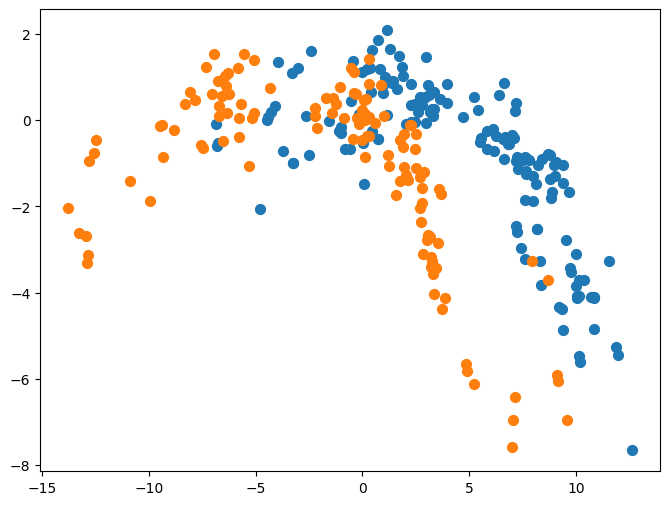

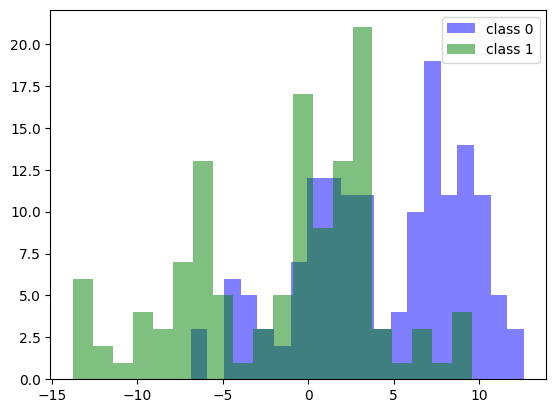

In [5]:
# Dimensions à étudier (à répéter pour d'autres dimensions)
feat1 = 1
feat2 = 3

# Distributions 2D
show_data_2D(X_train[:,[feat1, feat2]], y_train)
plt.show()

# Visualise les distributions pour un attribut
a0 = X0[:,feat1]
a1 = X1[:,feat1]

# Histogrammes des valeurs d'attributs pour chacune des classes
plt.hist(a0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(a1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()



### Autre manière de visualiser directement les données (en utilisant seaborn+pandas)

[Seaborn](https://seaborn.pydata.org/index.html) est une bibliothèque python très complète de visualisation de données. Elle contient des fonctions sophistiquées de rendu (exemple ci-dessous).


[Pandas](https://pandas.pydata.org/) est une bibliothèque de gestion et de manipulation de données. La structure de référence est le [*DataFrame*](https://pandas.pydata.org/docs/reference/frame.html) qui organise les données en champs indéxés par des étiquettes.

A partir des différents diagrammes, identifier les attributs individuels les plus informatifs pour la classification.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      1372 non-null   float32
 1   V2      1372 non-null   float32
 2   V3      1372 non-null   float32
 3   V4      1372 non-null   float32
 4   class   1372 non-null   int64  
dtypes: float32(4), int64(1)
memory usage: 32.3 KB


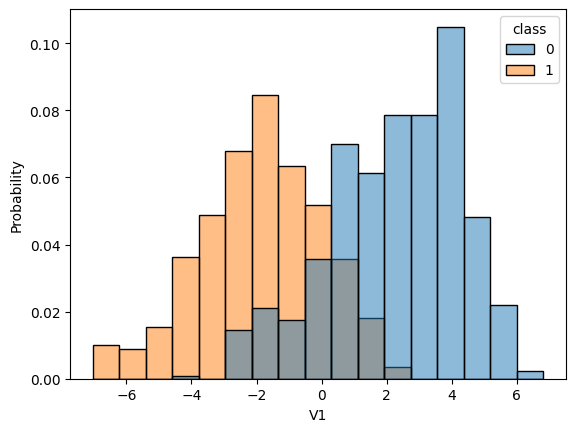

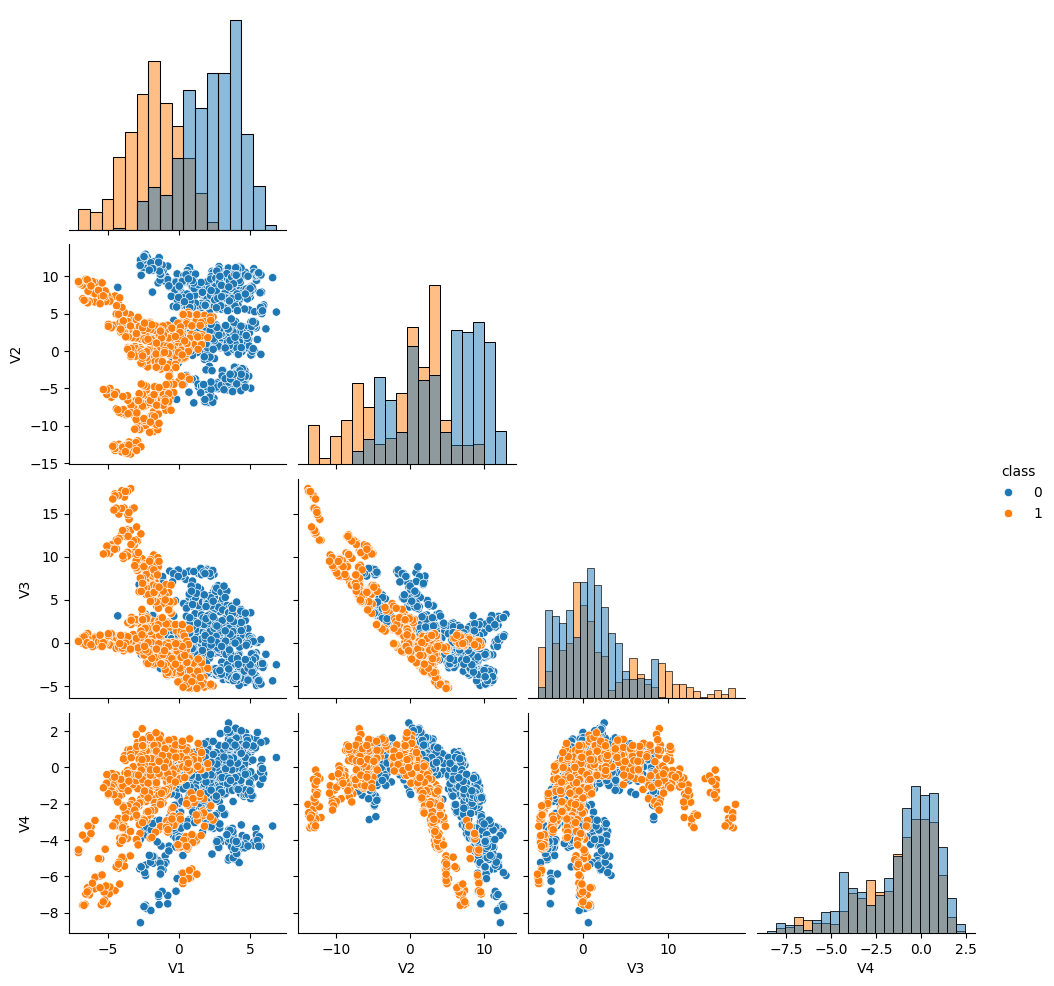

In [6]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(X, columns=names[:-1])
df['class'] = np.int64(y)

df.info()

sns.histplot(data=df, x='V1', hue='class', stat='probability')

sns.pairplot(df, hue='class',diag_kind="hist",corner=True)

## Construire une "baseline"

### Un premier essai de classification: chercher la meilleure caractéristique

* Modélisation des distributions 1D
* Construire un prédicteur pour chaque dimension
* Trouver la meilleure dimension à discriminer pour définir une "baseline" (= un algorithme simple de référence)

Vous pouvez regarder la bibliothèque [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) qui définit les familles courantes de distributions statistiques.

Essayez d'estimer quelques lois paramétriques pertinentes (méthode 'fit' des classes de scipy.stats) en les superposant aux histogrammes des données à parir du code ci-dessous. Jouer sur les différents paramètres pour visualiser les bonnes et mauvaises distributions.


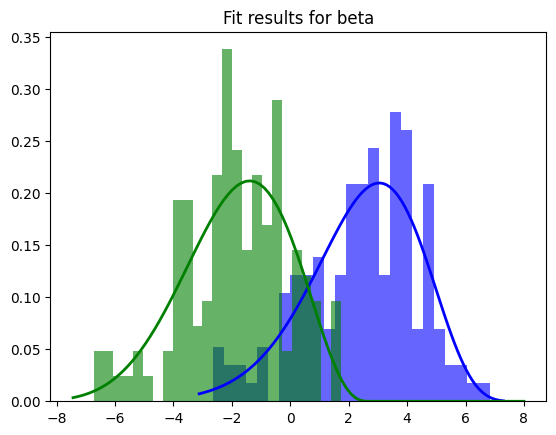

In [8]:
# Choix de la distribution
from scipy.stats import laplace, expon, norm, gamma, beta, cauchy, logistic

# Définit le type de distribution
distrib=beta

# Choix de la caractéristique
feat1 = 0
a0 = X0[:,feat1]
a1 = X1[:,feat1]

# Visualise les distributions pour une caractéristique
plt.clf()

data = a0
param = distrib.fit(data)

# Visualise l'histogramme
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Visualise la PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = distrib.pdf(x, *param)
plt.plot(x, p, 'b', linewidth=2)

data = a1
param = distrib.fit(data)

# Visualise l'histogramme
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Visualise la PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = distrib.pdf(x, *param)
plt.plot(x, p, 'g', linewidth=2)

title = "Fit results for %s" % distrib.name
plt.title(title)

plt.show()


Une fois le type de distribution choisi, construire une étape de classification simple. Par exemple, en calculant le signe du log-rapport des probabilités a posteriori: $\log(P[y=1|x]) - \log(P[y=0|x])$ en appliquant la loi de Bayes.

Pour rappel, la loi de Bayes est:
$$P[y|x] = \frac{P[x|y].P[y]}{P[x]}$$

Les log-vraisemblances conditionnelles $P[x|y]$ seront calculées en estimant les paramètres des modèles de distribution (cf. code précédent) et en appliquant la fonction `logpdf`sur la distribution.

La prise en compte des lois a priori $P[y]$ peut également être réalisée en calculant directement le ratio $\log \frac{P[y=1]}{P[y=0]} = \log \frac{|C_1|}{|C_2|}$ où $|C_k|$ est le nombre d'échantillons de la classe $k$ dans la base d'apprentissage.

Coder les étapes permettant d'estimer les paramètres des lois modélisant les distributions d'attributs, de construire le prédicteur à partir de ces lois, et d'évaluer la qualité du prédicteur.


In [ ]:
import math

# Calcul des log prior
logprior = math.log((y_train==0).sum()/(y_train==1).sum())

# Choix de la caractéristique
feat1 = 0

# Données d'apprentissage
a0 = X0[:,feat1]
a1 = X1[:,feat1]

# Données de test
at = X_test[:, feat1]

distrib = norm # ou une autre distribution

# Estimation des paramètres des lois et prédiction sur données de test
# les prédictions sont dans y_pred
# les valeurs dans l'espace de décision (log ratio probab) sont dans z_pred
#########################
## METTRE VOTRE CODE ICI

# Fonction d'estimation des paramètres du modèle
# et de calcul de la log vraisemblance
def compute_llk(a_train, a_test, distrib=norm):
  # Estime les maramètres de la distribution
  param = distrib.fit(a_train)
  # Calcule la log vraisemblance pour les données de test
  llk = distrib.logpdf(a_test, *param)

  return llk, param

# Calcule les log vraisemblances pour les données de test
l0t,_ = compute_llk(a0, at, distrib)
l1t,_ = compute_llk(a1, at, distrib)

z_pred = l1t - l0t - logprior

# Prédit en fonction du signe du rapport des probabilités a posteriori z_pred (à calculer)
y_pred = (z_pred > 0).astype('int')

##########################

# Calcul de l'erreur de prédiction (comparaison avec la vérité terrain y_test)
erreur = (y_pred != y_test).sum() / y_test.size

print("L'erreur de prédiction est {:.1f}%".format(100*erreur))



**Visualisation des log probabibilités**

On visualise les distributions des log probabilités par des histogrammes pour rendre compte de la capacité du prédicteur à les discriminer.

ATTENTION: on ne visualise pas la répsrtition des données dans l'espace des caractéristiques, mais leur projection dans l'espace de décision.

In [ ]:
# Si z_pred est la valeur du log ratio des probabilités a posteriori (à calculer)
# on visualise ici les distributions de sa valeur pour les deux classes

Z0 = z_pred[y_test == 0]
Z1 = z_pred[y_test == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


Quelles sont les performances d'un tel classifieur? Pourquoi sont-elles faibles?



---


# Partie 2: Comparaison des approches génératives et discriminantes




---

Dans cette partie, nous allons tester différentes approches d'apprentissage qui prennent en compte la nature multivariée des données. On a vu en effet dans la section précédente que chaque attribut ou caractéristique pris individuellement était peu discriminant.

Deux types d'approches permettent de construire des prédicteurs multi-variés: génératives, qui s'appuient sur une modélisation des données, et discriminantes, qui estiment directement les paramètres du prédicteur.


## Modèles génératifs

Nous allons tester deux types de modèles génératifs qui s'appuient sur une estimation des probabilités a posteriori pour construire la fonction de prédiction: la modélisation gaussienne multivariée, et l'approchche bayésienne naïve.

### Modélisation gaussienne multi-variée

Dans cette approche, l'objectif est d'estimer les paramètres d'un modèle gaussien multi-varié à partir des données d'apprentissage, et ensuite de comparer les probabilités a posteriori.

Le modèle Gaussien multi-varié est défini par la fonction [`multivariate_normal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal) et prend comme arguments les moyennes et covariance qu'il faut estimer par ailleurs, par exemple en utilisant les fonctions numpy [`mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) et [`cov`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html).

D'autres méthodes plus robustes peuvent être utilisées pour estimer la [matrice de covariance](https://scikit-learn.org/stable/modules/covariance.html#covariance).

Remarquer que le modèle `multivariate_normal` permet d'estimer directement le logarithme de la densité de probabilité (`logpdf`) pour pouvoir ensuite comparer le signe de la différence des log-probabilités pour décider.

Quelles sont les performances de cette approche?

In [ ]:
import math
from scipy.stats import multivariate_normal

# Calcul des log prior
logprior = math.log((y_train==0).sum()/(y_train==1).sum())

# Calcul des moyennes et covariances
cc0=np.cov(np.transpose(X0))
mm0=np.mean(X0,axis=0)

cc1=np.cov(np.transpose(X1))
mm1=np.mean(X1,axis=0)

# Apprentissage des lois et prédiction sur données de test
# les prédictions sont dans y_pred
# les valeurs dans l'espace de décision sont dans z_pred
#########################
### METTRE VOTRE CODE ICI


############################

# Evaluation
erreur = (y_pred != y_test).sum() / y_test.size

print("Gaussien multivarié: L'erreur de prédiction est {:.1f}%".format(100*erreur))


In [ ]:
# Visualisation de la valeur de la fonction de décision

Z0 = z_pred[y_test==0]
Z1 = z_pred[y_test==1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()



### Bayésien naïf

On se propose à partir de maintenant d'utiliser la librarie [scikit-learn](http://scikit-learn.org/stable/modules/classes.html) qui contient un grand nombre d'algorithmes d'apprentissage et une interface "orientée objet" facile d'utilisation.

Toutes les méthodes contiennent les fonctions suivantes:
* `fit`: pour apprendre/estimer les paramètres du modèle.
* `predict`: pour prédire (classe, valeur) à partir du modèle appris.
* `score`: pour calculer les performances du prédicteur.


Le principe du bayésien naïf est d'estimer la loi conditionnelle $P[x_i | y]$ pour les différentes hypothèses $y\in\{0,1\}$ et chaque caractéristique $x_i$ et d'appliquer ensuite l'inversion bayésienne avec hypothèse d'indépendance pour calculer la probabilité (ou log probabilité) a posteriori pour chacune des classes $y$ et une donnée à prédire $\mathbf{x}$.

$$\log P[y|\mathbf{x}] \propto \sum_{i=1}^d \log P[x_i|y] + \log P[y]$$

L'apprentissage consiste donc à estimer un bon modèle de la distribution de chaque caractéristique (binomiale, multinomiale, gaussienne, histogram, mélange de gaussienne...)

Regarder les différents modèles ["bayésiens naïfs"](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) de scikit-learn et déterminer la bonne classe à appliquer, et si elle est applicable, en fonction de l'allure des distributions de caractéristiques étudiées dans la partie 1.

Compléter le code ci-dessous pour vérifier le choix du modèle, et ses paramètres éventuels.

In [ ]:
from sklearn.naive_bayes import GaussianNB # code à compléter

#Coder les étapes d'apprentissage et de prédiction sur les données de test
# les prédictions sont dans y_pred
# les valeurs dans l'espace de décision sont dans z_pred
########################
## METTRE VOTRE CODE ICI

##########################

# Evaluation de l'erreur de la prédiction y_pred
erreur = (y_pred != y_test).sum() / y_test.size

print("Bayésien naïf: L'erreur de prédiction est {:.2f}%".format(100*erreur))

# Autre manière de calculer l'erreur directement (fonction score = predict + evaluation)
print("Bayésien naïf: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))


In [ ]:
#Visualisation du log du ratio des probabilités selon les classes

Z0 = z_pred[y_test == 0]
Z1 = z_pred[y_test == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


<mark>QUESTIONS:</mark>

* Comparer les performances du Bayésien naïf et des classifieurs de caractéristiques?

* Comment expliquer la différence de performance entre les deux approches (Gaussien multivarié et Bayésien Naïf)?


## Modèles discriminants

On a vu dans le cours trois manière d'estimer un modèle discriminant **linéaire**:

* moindres carrés
* régression logistique
* analyse discriminante avec critère de Fisher

On va les étudier dans la suite de cette section.

### Moindres carrés

Le code ci-dessous construit la fonction de prédiction en utilisant la fonction de régression linéaire [`linear_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Reportez-vous au cours pour analyser le rôle des différents éléments de code. Comment est réalisée la prédiction?

Les performances du prédicteur peuvent-elles être améliorées? Comparer la distribution des données avec la manière dont est prise la décision.


In [ ]:
from sklearn import linear_model

reg = linear_model.LinearRegression()

# Augmentation de la dimension des données pour estimer le biais
X_train1 = np.hstack((X_train,np.ones((X_train.shape[0], 1)) ))
X_test1 = np.hstack((X_test,np.ones((X_test.shape[0], 1)) ))

# Apprentissage
reg.fit(X_train1, y_train)
w_reg = reg.coef_

# Prédiction
z_pred = reg.predict(X_test1)
y_pred = (z_pred > 0.5).astype(int)

# Evaluation
erreur = (y_pred != y_test).sum() / y_test.size

print("Moindres carrés: L'erreur de prédiction est {:.2f}%".format(100*erreur))

# Visualisation des distributions de données d'apprentissage projetées sur la direction discriminante
Z0 = z_pred[y_test == 0]
Z1 = z_pred[y_test == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


### Régression logistique

La régression logistique consiste à estimer directement la loi a posteriori par une forme linéaire. Ses paramètres peuvent être calculés en utilisant la fonction
[`LogisticRregression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) de scikit-learn.

Construire le prédicteur, estimer ses performances et visualiser la distribution des données dans l'espace de décision.

Dans scikit-learn, on peut accéder à l'espace de décision (avant prédiction) par `decision_function` (pour générer `z_pred`).


In [ ]:
from sklearn.linear_model import LogisticRegression

# Apprentissage, prédiction et évaluation
#######################
# METTRE VOTRE CODE ICI

############################

Z0 = z_pred[y_test == 0]
Z1 = z_pred[y_test == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


### Analyse discriminante (Fisher)

L'analyse discriminante utilisant le critère de contraste de Fisher pour un problème à deux classes consiste à calculer la direction discriminante $\mathbf{w}$ selon
$$\mathbf{w} = S_I^{-1}.(\mathbf{\mu}_1 - \mathbf{\mu}_0)$$
où $\mu_k$ est la moyenne des données pour la classe $k$ et la matrice $S_I$ mesure la disparité intra-classe et vaut $\Sigma_0 + \Sigma_1$, la somme des matrices de covariance de chacune des classes.

Calculer la direction discriminante et visualiser les histogrammes des données projetées. Déterminer à partir de la visualisation un seuil de détection (le biais) pour discrirminer classe 0 vs. classe 1 et calculer l'erreur de prédiction.

Rappel: le produit matriciel peut se calculer sous numpy par la fonction [`dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), l'inversion par [`inv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) et le calule de la norme par [`norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

In [ ]:
from numpy.linalg import inv, norm

cc0=np.cov(np.transpose(X0))
mm0=np.mean(X0,axis=0)

cc1=np.cov(np.transpose(X1))
mm1=np.mean(X1,axis=0)

# Apprentissage (calcul de la direction discriminante)
#######################
# METTRE VOTRE CODE ICI

#######################################

# Prédiction (w est la direction, b est le biais)
z_pred = np.dot(X_test, w) - b
y_pred = (z_pred>0).astype(int)

print("Fisher LDA: L'erreur de prédiction est {:.1f}%".format(100*(y_pred != y_test).sum() / y_test.size))

Z0 = z_pred[y_test == 0]
Z1 = z_pred[y_test == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


Une autre manière d'implémenter une analyse discriminante linéaire est d'utiliser la fonction  [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)de scikit-learn. Cette version fait l'hypothèse que les matrices de covariance pour les deux classes sont identiques.

On peut montrer que sous cette hypothèse, la direction discriminante est la même que celle obtenue par moindre carré: vérifier le empiriquement. La direction discriminante est accessible comme une variable `coef_` du modèle.

Inspirez-vous des code précédents pour estimer le modèle, faire la prédiction, et visualiser les distributions dans l'espace de décision.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Apprentissage, prédiction et évaluation et comparaison des résultats
# avec ceux du prédicteur aux moindres carrés
#######################
# METTRE VOTRE CODE ICI


###########################

Z0 = z_pred[y_test == 0]
Z1 = z_pred[y_test == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


# Partie 3: Autres jeux de données

On se propose dans cette partie de comparer les comportements des prédicteurs étudiés précédemment sur d'autres jeux de données.

## Un dataset de taille intermédiaire

Ce [jeu de données](https://www.openml.org/search?type=data&sort=runs&id=1471&status=active) est un peu plus grand que le précédent (détection de faux billets) en dimension des données et quantité. Il a pour objectif de prédire à partir de signaux d'électro-encéphalogramme si les yeux sont ouverts ou fermés.

On cherchera donc encore ici à réaliser une classification parmi deux hypothèses.


In [ ]:
import openml

# List all datasets and their properties
#openml.datasets.list_datasets(output_format="dataframe")

# Get dataset by ID
#dataset = openml.datasets.get_dataset(1471)

# Get dataset by name
dataset = openml.datasets.get_dataset('eeg-eye-state')

# Get the data itself as a dataframe (or otherwise)
data_all, _, _, names = dataset.get_data(dataset_format="array")

y = data_all[:,-1]
X = data_all[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.8)


X0 = X_train[y_train == 0,:]
X1 = X_train[y_train == 1,:]

print("Les données sont de dimension {:d}".format(X_train.shape[1]))
print("Le nombre de données d'apprentissage est {:d}".format(y_train.shape[0]))


### Visualisation des données

Regarder et visualiser les données sur quelques dimensions pour se faire une idée de leur distribution. On pourra faire une boucle sur les caractéristiques pour comparer les histogrammes, et regarder les corrélations des caractéristiques.

Qu'en conclure sur la difficulté du problème? Quels sont les approches potentiellement intéressantes?

In [ ]:
# Visualisation des données
#######################################
## METTRE VOTRE CODE ICI

####################################

### Analyse discriminante

Reprendre les codes de la section précédente, et estimer les performances du modèle.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()

clf.fit(X_train, y_train)
print("L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

z_pred = clf.decision_function(X_train)

Z0 = z_pred[y_train == 0]
Z1 = z_pred[y_train == 1]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


### Gaussien multivarié

Reprendre les codes de la section précédente, et estimer les performances du modèle.

In [ ]:
from scipy.stats import multivariate_normal

X0 = X_train[y_train == 0,:]
X1 = X_train[y_train == 1,:]

cc0=np.cov(np.transpose(X0))
mm0=np.mean(X0,axis=0)
d0 = multivariate_normal(mean=mm0, cov=cc0)

cc1=np.cov(np.transpose(X1))
mm1=np.mean(X1,axis=0)
d1 = multivariate_normal(mean=mm1, cov=cc1)

lk0=d0.logpdf(X_test)
lk1=d1.logpdf(X_test)

y_pred = (lk1 - lk0 > 0).astype('int')

print("Gaussien multivarié: L'erreur de prédiction est {:.1f}%".format(100*(y_pred != y_test).sum() / y_test.size))


In [ ]:
z_pred = lk1 - lk0

Z0 = z_pred[y_test==0]
Z1 = z_pred[y_test==1]


# Pour limiter l'étendu de la visualisation (existence de valeurs très grandes ou très petites) on filtre les quantiles extrémes.
from scipy.stats.mstats import mquantiles

Z0_quant = mquantiles(Z0, prob=[0.01, 0.99])
Z0 = Z0[Z0 > Z0_quant[0]]
Z0 = Z0[Z0 < Z0_quant[1]]

Z1_quant = mquantiles(Z1, prob=[0.01, 0.99])
Z1 = Z1[Z1 > Z1_quant[0]]
Z1 = Z1[Z1 < Z1_quant[1]]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


### Régression logistique

Reprendre les codes de la section précédente, et estimer les performances du modèle.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='liblinear', C=100000).fit(X_train, y_train)
print("Régression logisitique: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

z_pred = clf.decision_function(X_test)

Z0 = z_pred[y_test==0]
Z1 = z_pred[y_test==1]

from scipy.stats.mstats import mquantiles

Z0_quant = mquantiles(Z0, prob=[0.01, 0.99])
Z0 = Z0[Z0 > Z0_quant[0]]
Z0 = Z0[Z0 < Z0_quant[1]]

Z1_quant = mquantiles(Z1, prob=[0.01, 0.99])
Z1 = Z1[Z1 > Z1_quant[0]]
Z1 = Z1[Z1 < Z1_quant[1]]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()



<mark>QUESTION</mark>
* Quel modèle semble le plus intéressant pour ce problème?
* Avez-vous une explication de la différence de comportement des approches?

### Augmentation de caractéristiques + LDA

Dans cette partie, on se propose d'augmenter l'expressivité des caractéristiques en rajoutant des moments d'ordre 2 dans la représentation. Cela peut se faire en utilisant la fonction [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

La logique derrière cette augmentation de représentation est de construire artificiellement une surface de décision plus complexe mais en gardant un mécanisme d'estimation s'appuyant sur des techniques linéaires.

On construit une fonction $\Phi: \mathbf{x} \mapsto \Phi(\mathbf{x}) \in R^m$ qui transforme les données d'origine dans $R^d$ dans une espace $R^m$ où, en général, $m > n$. Par exemple, on va construire des produits de chaque caractéristique $\Phi_k(\mathbf{x}) = x_i.x_j$. La direction de décision $\mathbf{w}$ sera alors à rechercher dans $R^m$ et la fonction de décision:
$$z(\mathbf{x}) = w_0 + w_1.\Phi_1(\mathbf{x}) + \cdots w_k.\Phi_k(\mathbf{x})$$
Si l'on augmente ainsi les représentations, on peut générer des surfaces de décision quadratiques.

Utiliser cette démarche pour construire une fonction de décision quadratique en augmentant les représentations avec la fonction `PolynomialFeatures`.



In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

Xp_train = poly.fit_transform(X_train)
Xp_test = poly.fit_transform(X_test)

# Apprentissage et calcul de z_pred (espace de décision)
######################################
## METTRE VOTRE CODE ICI

clf = LinearDiscriminantAnalysis()
clf.fit(Xp_train, y_train)

z_pred = clf.decision_function(Xp_test)

#####################################

Z0 = z_pred[y_test==0]
Z1 = z_pred[y_test==1]

from scipy.stats.mstats import mquantiles

Z0_quant = mquantiles(Z0, prob=[0.001, 0.999])
Z0 = Z0[Z0 > Z0_quant[0]]
Z0 = Z0[Z0 < Z0_quant[1]]

Z1_quant = mquantiles(Z1, prob=[0.001, 0.999])
Z1 = Z1[Z1 > Z1_quant[0]]
Z1 = Z1[Z1 < Z1_quant[1]]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()

print("L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(Xp_test, y_test))))

### Augmentation de caractéristiques + Régression logistique

Même principe mais avec régression logistique. Ici, l'apprentissage de la fonction a nécessité de normaliser les données pour assurer la convergence de l'optimisation.

In [ ]:
poly = PolynomialFeatures(2)

Xp_train = poly.fit_transform(X_train)
Xp_test = poly.fit_transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear', C=10, penalty='l2')
clf.fit(Xp_train, y_train)

z_pred = clf.decision_function(Xp_test)

print("Régression logisitique: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(Xp_test, y_test))))


from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(Xp_train)

Xp_scaled = scaler.transform(Xp_train)
Xp_test_scaled = scaler.transform(Xp_test)

clf = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear', C=10000, penalty='l2')
clf.fit(Xp_scaled, y_train)

z_pred = clf.decision_function(Xp_test_scaled)

print("Régression logisitique + augmentation: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(Xp_test_scaled, y_test))))


In [ ]:

Z0 = z_pred[y_test==0]
Z1 = z_pred[y_test==1]

from scipy.stats.mstats import mquantiles

Z0_quant = mquantiles(Z0, prob=[0.01, 0.99])
Z0 = Z0[Z0 > Z0_quant[0]]
Z0 = Z0[Z0 < Z0_quant[1]]

Z1_quant = mquantiles(Z1, prob=[0.01, 0.99])
Z1 = Z1[Z1 > Z1_quant[0]]
Z1 = Z1[Z1 < Z1_quant[1]]

plt.hist(Z0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(Z1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


### SVM (pour plus tard)

Les Support Vector Machines permettent de mieux contrôler la surface discrimante et sa forme. On les étudiera dans le cours N°4.

Ici, ils donnent d'assez bonnes performances sur ce problème très mélangé.

In [ ]:
from sklearn import svm

clf = svm.SVC(shrinking=True,max_iter=1000000,gamma=1e-3, C=3.5, kernel='rbf')

clf.fit(X_train, y_train)
print("SVM: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

z_pred = clf.decision_function(X_test)

a0 = z_pred[y_test==0]
a1 = z_pred[y_test==1]

plt.hist(a0, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(a1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Pour rechercher par validation croisée les bons paramètres

# # Import de la classe pour Validation Croisée
# from sklearn.model_selection import GridSearchCV

# svc = svm.SVC(shrinking=True,max_iter=1000000,gamma='auto') # max_iter = 1000000 pour limiter les non convergences de l'optimiseur

# parameters = [{'kernel':['rbf'],
#               'C':np.logspace(-2, 2, 7),
#               'gamma':np.logspace(-3, 2, 10)},
#               {'kernel':['poly'],
#               'C':np.logspace(-2, 2, 7),
#               'degree':[2,3,4]}]

# parameters = {'kernel':['rbf'],
#               'C':np.logspace(0, 1, 7),
#               'gamma':np.logspace(-4, -2, 10)}

# clf = GridSearchCV(svc, parameters, cv=2)
# clf.fit(X_train, y_train)

# bestsvc = clf.best_estimator_

# print("Best score = {:.2f}% with kernel {}".format(100*(1-clf.best_score_), bestsvc.kernel))
# if bestsvc.kernel == 'rbf':
#     print("Parameters are gamma = {:.2g} and C = {:2g}".format(bestsvc.gamma, bestsvc.C))
# elif bestsvc.kernel == 'poly':
#     print("Parameters are degree = {} and C = {:2g}".format(bestsvc.degree, bestsvc.C))

# print("SVM: L'erreur de prédiction est {:.2f}%".format(100*(1-bestsvc.score(X_test, y_test))))


## Un dataset de très grande dimension

Le nouveau problème d'apprentissage est une classification binaire de textes en provenance de newsgroups, c'est-à-dire des forums de discussion sur une certaine thématique. L'objectif de la classification est de prédire le groupe où le document a été posté uniquement à partir du texte.

Une première étape de mise en forme des données sous forme vectorielle a été réalisée et utilise une technique de "sac de mots" ("bag of words" en anglais). Les données sont de grande taille.

Calculer le nombre moyen de valeurs non nulles par échantillon: qu'en déduisez-vous sur la structure des données?


<div class="alert alert-block alert-info">

Chargez les données visualisez quelques exemples. Calculez le nombre moyen de valeurs non nulles par échantillon.

</div>

In [ ]:
import scipy
from sklearn import datasets

X_ori, y_ori = datasets.fetch_20newsgroups_vectorized(subset="all", return_X_y=True)

## Lecture des données
#class0 = 3 #'comp.sys.ibm.pc.hardware',
#class1 = 4 #'comp.sys.mac.hardware'

class0 = 13 # 'sci.med'
class1 = 14 # 'sci.space'

X0 = X_ori[y_ori == class0,:]
X1 = X_ori[y_ori == class1,:]

y_all = np.array([0]*X0.shape[0] + [1]*X1.shape[0])
X_all = scipy.sparse.vstack((X0,X1))

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                    random_state=42,
                                                    test_size=0.3)

print("Les données sont de dimension {:d}".format(X_train.shape[1]))
print("Le nombre de données d'apprentissage est {:d}".format(y_train.shape[0]))



In [ ]:
# Analyse des données
#######################
# METTRE VOTRE CODE ICI


# Calcul du nombre moyens d'éléments non nuls
non_nul_moyen = 4568741
print("Le nombre moyen de valeurs non nulles par échantillon est {:.1f}".format(non_nul_moyen))


### Bayésien naïf


Mise en oeuvre du bayésien naïf.

Ici, les représentations étant des histogrammes de fréquence de mots, les modèles de probabilité par dimension sont soit des Bernoulli (présence/absence d'une caractéristique), soit des lois multinomiales (nombre d'occurrences de mots).

In [ ]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

clf = BernoulliNB()
#clf = MultinomialNB()

clf.fit(X_train, y_train)

print("Bayésien naïf: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

### Prédicteurs discriminants

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LogisticRegression(random_state=0, solver='lbfgs', penalty='none').fit(X_train, y_train)
print("Régression logisitique: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

# Ici, le SVM n'est pas calculé dans le dual (on verra ce que ça veut dire au cours N°4)
clf=LinearSVC(random_state=0, tol=1e-5, dual=False, C=1).fit(X_train, y_train)
print("SVM linéaire: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))

# Pour des données de très grande dimension, le calcul directe de la direction discriminante
# (par estimation de la covariance ou des valeurs propres) est trop calculatoire
#clf = LinearDiscriminantAnalysis()
#clf.fit(X_train.toarray(), y_train)
#print("Analyse discriminante: L'erreur de prédiction est {:.2f}%".format(100*(1-clf.score(X_test, y_test))))



Pour ce type de données de grande taille mais creuses (beaucoup d'attributs nuls) le bayésien naïf est une solution simple et efficace.